In [151]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

In [234]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
MASK_PATH = 'C://Users//sahan//ipthw//Melanoma_segmentation//data//mask'
Image_PATH = 'C://Users//sahan//ipthw//Melanoma_segmentation//data//train'
VALID_PATH = 'C://Users//sahan//ipthw//Melanoma_segmentation//data//val'
Test_PATH = 'C://Users//sahan//ipthw//Melanoma_segmentation//data//test'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [198]:
mask_ids = next(os.walk(MASK_PATH))[2]
image_ids = next(os.walk(Image_PATH))[2]
val_ids = next(os.walk(VALID_PATH))[2]
test_ids = next(os.walk(Test_PATH))[2]
mask_ids[1]

'ISIC_0000001_segmentation.png'

In [154]:
X_train = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)

In [163]:
Y_train = np.zeros((len(mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [156]:
Valid = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)

In [157]:
img = imread(MASK_PATH  + '//' + mask_ids[1])
img.ndim
    

2

In [39]:
sys.stdout.flush()
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = Image_PATH
    img = imread(path + '//' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    


100%|██████████████████████████████████████████████████████████████████████████████| 2594/2594 [14:47<00:00,  2.34it/s]


In [166]:
for n, id_ in tqdm(enumerate(mask_ids), total=len(image_ids)):
    mask_ = imread(MASK_PATH +'//'+id_)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    
    Y_train[n] = mask_

100%|██████████████████████████████████████████████████████████████████████████████| 2594/2594 [02:36<00:00, 16.58it/s]


In [237]:
val_test = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_valid = []

for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
    path = VALID_PATH
    img = imread(path + '//'+  id_)[:,:,:IMG_CHANNELS]
    sizes_valid.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    val_test[n] = img

print('Done!')





  0%|                                                                                          | 0/100 [00:00<?, ?it/s]



  1%|▊                                                                                 | 1/100 [00:00<00:48,  2.03it/s]



  2%|█▋                                                                                | 2/100 [00:00<00:41,  2.38it/s]



  5%|████                                                                              | 5/100 [00:00<00:28,  3.29it/s]



  8%|██████▌                                                                           | 8/100 [00:00<00:20,  4.47it/s]


  4%|███                                                                             | 39/1000 [00:19<07:53,  2.03it/s]



 10%|████████                                                                         | 10/100 [00:03<00:49,  1.83it/s]



 12%|█████████▋                                                                       | 12/100 [00:06<01:07,  1.30it/s]



 13%|████████

Done!


In [238]:
TEST = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_valid = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = Test_PATH
    img = imread(path + '//'+  id_)[:,:,:IMG_CHANNELS]
    sizes_valid.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    TEST[n] = img

print('Done!')





  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]



  0%|                                                                                 | 1/1000 [00:00<04:15,  3.92it/s]



  0%|▏                                                                                | 2/1000 [00:00<05:25,  3.06it/s]



  0%|▏                                                                                | 3/1000 [00:00<05:01,  3.31it/s]



  0%|▎                                                                                | 4/1000 [00:01<04:45,  3.49it/s]



  0%|▍                                                                                | 5/1000 [00:01<04:36,  3.60it/s]



  1%|▍                                                                                | 6/1000 [00:02<05:44,  2.89it/s]



  1%|▌                                                                                | 7/1000 [00:02<05:14,  3.16it/s]



  1%|▋      

  8%|██████▊                                                                         | 85/1000 [01:08<19:02,  1.25s/it]



  9%|██████▉                                                                         | 86/1000 [01:09<18:50,  1.24s/it]



  9%|██████▉                                                                         | 87/1000 [01:10<18:51,  1.24s/it]



  9%|███████                                                                         | 88/1000 [01:11<19:01,  1.25s/it]



  9%|███████                                                                         | 89/1000 [01:13<18:48,  1.24s/it]



  9%|███████▏                                                                        | 90/1000 [01:14<19:12,  1.27s/it]



  9%|███████▎                                                                        | 91/1000 [01:15<19:21,  1.28s/it]



  9%|███████▎                                                                        | 92/1000 [01:16<19:28,  1.29s/it]



  9%|███████▍   

IndexError: index 100 is out of bounds for axis 0 with size 100

(2594, 128, 128, 1)


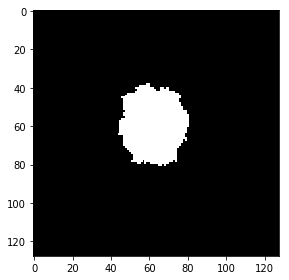

In [167]:
print(Y_train.shape)
imshow(np.squeeze(Y_train[1]))
plt.show()


In [179]:
#https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/Data_Science_Bowl_2018.ipynb
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [202]:
def get_unet(IMG_WIDTH=128,IMG_HEIGHT=128,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optim,loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [209]:
model = get_unet()

In [208]:
from keras.optimizers import RMSprop
earlystopper = EarlyStopping(patience=5, verbose=1)

optim = RMSprop(lr = 0.001, decay = 1e-6)

In [210]:
results = model.fit(X_train, Y_train, batch_size=32, epochs=50)

Epoch 1/50
2594/2594 [==============================] - ETA: 2:43 - loss: 0.6931 - dice_coef: 0.291 - ETA: 1:22 - loss: 0.6795 - dice_coef: 0.285 - ETA: 55s - loss: 0.6416 - dice_coef: 0.269 - ETA: 42s - loss: 0.6446 - dice_coef: 0.25 - ETA: 34s - loss: 2.3052 - dice_coef: 0.26 - ETA: 24s - loss: 1.9241 - dice_coef: 0.28 - ETA: 19s - loss: 1.6962 - dice_coef: 0.28 - ETA: 15s - loss: 1.5381 - dice_coef: 0.28 - ETA: 13s - loss: 1.3888 - dice_coef: 0.27 - ETA: 11s - loss: 1.2827 - dice_coef: 0.27 - ETA: 10s - loss: 1.1946 - dice_coef: 0.26 - ETA: 9s - loss: 1.1298 - dice_coef: 0.2621 - ETA: 8s - loss: 1.0742 - dice_coef: 0.258 - ETA: 7s - loss: 1.0279 - dice_coef: 0.255 - ETA: 6s - loss: 0.9898 - dice_coef: 0.255 - ETA: 6s - loss: 0.9557 - dice_coef: 0.251 - ETA: 5s - loss: 0.9280 - dice_coef: 0.251 - ETA: 5s - loss: 0.9063 - dice_coef: 0.250 - ETA: 4s - loss: 0.8820 - dice_coef: 0.248 - ETA: 4s - loss: 0.8601 - dice_coef: 0.245 - ETA: 4s - loss: 0.8428 - dice_coef: 0.243 - ETA: 3s - loss

2594/2594 [==============================] - ETA: 5s - loss: 0.3411 - dice_coef: 0.430 - ETA: 4s - loss: 0.3536 - dice_coef: 0.425 - ETA: 4s - loss: 0.3483 - dice_coef: 0.428 - ETA: 4s - loss: 0.3513 - dice_coef: 0.424 - ETA: 3s - loss: 0.3729 - dice_coef: 0.421 - ETA: 3s - loss: 0.3834 - dice_coef: 0.423 - ETA: 3s - loss: 0.3845 - dice_coef: 0.416 - ETA: 3s - loss: 0.3928 - dice_coef: 0.412 - ETA: 3s - loss: 0.3810 - dice_coef: 0.404 - ETA: 3s - loss: 0.3762 - dice_coef: 0.395 - ETA: 3s - loss: 0.3776 - dice_coef: 0.399 - ETA: 3s - loss: 0.3792 - dice_coef: 0.405 - ETA: 3s - loss: 0.3822 - dice_coef: 0.407 - ETA: 3s - loss: 0.3817 - dice_coef: 0.409 - ETA: 2s - loss: 0.3895 - dice_coef: 0.406 - ETA: 2s - loss: 0.3929 - dice_coef: 0.407 - ETA: 2s - loss: 0.3922 - dice_coef: 0.407 - ETA: 2s - loss: 0.3886 - dice_coef: 0.406 - ETA: 2s - loss: 0.3873 - dice_coef: 0.400 - ETA: 2s - loss: 0.3862 - dice_coef: 0.400 - ETA: 2s - loss: 0.3930 - dice_coef: 0.402 - ETA: 2s - loss: 0.3939 - dice_c

Epoch 9/50
2594/2594 [==============================] - ETA: 3s - loss: 0.4174 - dice_coef: 0.429 - ETA: 3s - loss: 0.4452 - dice_coef: 0.359 - ETA: 3s - loss: 0.4395 - dice_coef: 0.350 - ETA: 3s - loss: 0.4276 - dice_coef: 0.365 - ETA: 2s - loss: 0.4013 - dice_coef: 0.369 - ETA: 2s - loss: 0.3875 - dice_coef: 0.365 - ETA: 2s - loss: 0.3723 - dice_coef: 0.375 - ETA: 2s - loss: 0.3779 - dice_coef: 0.379 - ETA: 2s - loss: 0.3834 - dice_coef: 0.383 - ETA: 2s - loss: 0.3824 - dice_coef: 0.386 - ETA: 2s - loss: 0.3870 - dice_coef: 0.389 - ETA: 2s - loss: 0.3828 - dice_coef: 0.394 - ETA: 2s - loss: 0.3820 - dice_coef: 0.399 - ETA: 2s - loss: 0.3786 - dice_coef: 0.403 - ETA: 2s - loss: 0.3827 - dice_coef: 0.405 - ETA: 2s - loss: 0.3833 - dice_coef: 0.407 - ETA: 1s - loss: 0.3848 - dice_coef: 0.408 - ETA: 1s - loss: 0.3873 - dice_coef: 0.411 - ETA: 1s - loss: 0.3883 - dice_coef: 0.413 - ETA: 1s - loss: 0.3883 - dice_coef: 0.414 - ETA: 1s - loss: 0.3871 - dice_coef: 0.413 - ETA: 1s - loss: 0.39

2594/2594 [==============================] - ETA: 3s - loss: 0.4391 - dice_coef: 0.428 - ETA: 3s - loss: 0.4077 - dice_coef: 0.430 - ETA: 3s - loss: 0.4103 - dice_coef: 0.436 - ETA: 3s - loss: 0.4082 - dice_coef: 0.435 - ETA: 3s - loss: 0.4044 - dice_coef: 0.433 - ETA: 2s - loss: 0.4014 - dice_coef: 0.430 - ETA: 2s - loss: 0.4076 - dice_coef: 0.426 - ETA: 2s - loss: 0.3999 - dice_coef: 0.428 - ETA: 2s - loss: 0.3964 - dice_coef: 0.426 - ETA: 2s - loss: 0.4061 - dice_coef: 0.422 - ETA: 2s - loss: 0.4027 - dice_coef: 0.420 - ETA: 2s - loss: 0.4104 - dice_coef: 0.421 - ETA: 2s - loss: 0.4116 - dice_coef: 0.422 - ETA: 2s - loss: 0.4063 - dice_coef: 0.423 - ETA: 2s - loss: 0.4021 - dice_coef: 0.423 - ETA: 2s - loss: 0.4018 - dice_coef: 0.424 - ETA: 2s - loss: 0.4004 - dice_coef: 0.422 - ETA: 1s - loss: 0.4011 - dice_coef: 0.423 - ETA: 1s - loss: 0.4012 - dice_coef: 0.424 - ETA: 1s - loss: 0.4005 - dice_coef: 0.426 - ETA: 1s - loss: 0.4021 - dice_coef: 0.427 - ETA: 1s - loss: 0.4010 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.5301 - dice_coef: 0.487 - ETA: 3s - loss: 0.4513 - dice_coef: 0.422 - ETA: 3s - loss: 0.4093 - dice_coef: 0.415 - ETA: 3s - loss: 0.3897 - dice_coef: 0.416 - ETA: 3s - loss: 0.4014 - dice_coef: 0.410 - ETA: 3s - loss: 0.3941 - dice_coef: 0.414 - ETA: 3s - loss: 0.3947 - dice_coef: 0.418 - ETA: 2s - loss: 0.3953 - dice_coef: 0.420 - ETA: 2s - loss: 0.3920 - dice_coef: 0.424 - ETA: 2s - loss: 0.3953 - dice_coef: 0.426 - ETA: 2s - loss: 0.3934 - dice_coef: 0.427 - ETA: 2s - loss: 0.3888 - dice_coef: 0.430 - ETA: 2s - loss: 0.3883 - dice_coef: 0.429 - ETA: 2s - loss: 0.3854 - dice_coef: 0.430 - ETA: 2s - loss: 0.3860 - dice_coef: 0.429 - ETA: 2s - loss: 0.3846 - dice_coef: 0.429 - ETA: 2s - loss: 0.3887 - dice_coef: 0.429 - ETA: 2s - loss: 0.3878 - dice_coef: 0.429 - ETA: 1s - loss: 0.3881 - dice_coef: 0.428 - ETA: 1s - loss: 0.3916 - dice_coef: 0.428 - ETA: 1s - loss: 0.3902 - dice_coef: 0.427 - ETA: 1s - loss: 0.3901 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.4012 - dice_coef: 0.459 - ETA: 3s - loss: 0.4830 - dice_coef: 0.387 - ETA: 3s - loss: 0.4483 - dice_coef: 0.396 - ETA: 3s - loss: 0.4301 - dice_coef: 0.402 - ETA: 3s - loss: 0.4089 - dice_coef: 0.405 - ETA: 2s - loss: 0.4002 - dice_coef: 0.406 - ETA: 2s - loss: 0.3886 - dice_coef: 0.409 - ETA: 2s - loss: 0.3937 - dice_coef: 0.412 - ETA: 2s - loss: 0.3869 - dice_coef: 0.411 - ETA: 2s - loss: 0.3903 - dice_coef: 0.410 - ETA: 2s - loss: 0.3905 - dice_coef: 0.410 - ETA: 2s - loss: 0.3888 - dice_coef: 0.413 - ETA: 2s - loss: 0.3878 - dice_coef: 0.416 - ETA: 2s - loss: 0.3902 - dice_coef: 0.418 - ETA: 2s - loss: 0.3909 - dice_coef: 0.417 - ETA: 2s - loss: 0.3919 - dice_coef: 0.417 - ETA: 2s - loss: 0.3936 - dice_coef: 0.418 - ETA: 1s - loss: 0.3945 - dice_coef: 0.420 - ETA: 1s - loss: 0.3921 - dice_coef: 0.424 - ETA: 1s - loss: 0.3892 - dice_coef: 0.424 - ETA: 1s - loss: 0.3888 - dice_coef: 0.424 - ETA: 1s - loss: 0.3886 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.3844 - dice_coef: 0.325 - ETA: 3s - loss: 0.4291 - dice_coef: 0.369 - ETA: 3s - loss: 0.4052 - dice_coef: 0.386 - ETA: 3s - loss: 0.4092 - dice_coef: 0.393 - ETA: 3s - loss: 0.4096 - dice_coef: 0.394 - ETA: 3s - loss: 0.4078 - dice_coef: 0.400 - ETA: 2s - loss: 0.4025 - dice_coef: 0.403 - ETA: 2s - loss: 0.3973 - dice_coef: 0.409 - ETA: 2s - loss: 0.3958 - dice_coef: 0.410 - ETA: 2s - loss: 0.3911 - dice_coef: 0.414 - ETA: 2s - loss: 0.3896 - dice_coef: 0.420 - ETA: 2s - loss: 0.3942 - dice_coef: 0.423 - ETA: 2s - loss: 0.3948 - dice_coef: 0.422 - ETA: 2s - loss: 0.3901 - dice_coef: 0.421 - ETA: 2s - loss: 0.3927 - dice_coef: 0.420 - ETA: 2s - loss: 0.3943 - dice_coef: 0.424 - ETA: 2s - loss: 0.3927 - dice_coef: 0.425 - ETA: 1s - loss: 0.3927 - dice_coef: 0.427 - ETA: 1s - loss: 0.3967 - dice_coef: 0.427 - ETA: 1s - loss: 0.3983 - dice_coef: 0.425 - ETA: 1s - loss: 0.3977 - dice_coef: 0.423 - ETA: 1s - loss: 0.3962 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.4514 - dice_coef: 0.474 - ETA: 3s - loss: 0.4219 - dice_coef: 0.474 - ETA: 3s - loss: 0.4144 - dice_coef: 0.439 - ETA: 3s - loss: 0.4157 - dice_coef: 0.432 - ETA: 3s - loss: 0.3961 - dice_coef: 0.431 - ETA: 2s - loss: 0.3955 - dice_coef: 0.435 - ETA: 2s - loss: 0.4083 - dice_coef: 0.433 - ETA: 2s - loss: 0.4088 - dice_coef: 0.434 - ETA: 2s - loss: 0.4071 - dice_coef: 0.437 - ETA: 2s - loss: 0.4028 - dice_coef: 0.434 - ETA: 2s - loss: 0.4002 - dice_coef: 0.432 - ETA: 2s - loss: 0.3993 - dice_coef: 0.432 - ETA: 2s - loss: 0.3963 - dice_coef: 0.432 - ETA: 2s - loss: 0.3914 - dice_coef: 0.432 - ETA: 2s - loss: 0.3915 - dice_coef: 0.431 - ETA: 2s - loss: 0.3924 - dice_coef: 0.429 - ETA: 2s - loss: 0.3912 - dice_coef: 0.430 - ETA: 1s - loss: 0.3906 - dice_coef: 0.432 - ETA: 1s - loss: 0.3893 - dice_coef: 0.432 - ETA: 1s - loss: 0.3913 - dice_coef: 0.429 - ETA: 1s - loss: 0.3937 - dice_coef: 0.427 - ETA: 1s - loss: 0.3951 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.6303 - dice_coef: 0.253 - ETA: 3s - loss: 0.5198 - dice_coef: 0.289 - ETA: 3s - loss: 0.4647 - dice_coef: 0.330 - ETA: 3s - loss: 0.4632 - dice_coef: 0.350 - ETA: 3s - loss: 0.4328 - dice_coef: 0.363 - ETA: 2s - loss: 0.4122 - dice_coef: 0.376 - ETA: 2s - loss: 0.4072 - dice_coef: 0.383 - ETA: 2s - loss: 0.4033 - dice_coef: 0.388 - ETA: 2s - loss: 0.4034 - dice_coef: 0.391 - ETA: 2s - loss: 0.3999 - dice_coef: 0.394 - ETA: 2s - loss: 0.4018 - dice_coef: 0.398 - ETA: 2s - loss: 0.4043 - dice_coef: 0.401 - ETA: 2s - loss: 0.4056 - dice_coef: 0.405 - ETA: 2s - loss: 0.4054 - dice_coef: 0.409 - ETA: 2s - loss: 0.4032 - dice_coef: 0.412 - ETA: 2s - loss: 0.4010 - dice_coef: 0.413 - ETA: 2s - loss: 0.3983 - dice_coef: 0.414 - ETA: 1s - loss: 0.3965 - dice_coef: 0.417 - ETA: 1s - loss: 0.3980 - dice_coef: 0.420 - ETA: 1s - loss: 0.3997 - dice_coef: 0.421 - ETA: 1s - loss: 0.3979 - dice_coef: 0.422 - ETA: 1s - loss: 0.3975 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.2733 - dice_coef: 0.380 - ETA: 3s - loss: 0.3298 - dice_coef: 0.410 - ETA: 3s - loss: 0.3607 - dice_coef: 0.427 - ETA: 3s - loss: 0.3816 - dice_coef: 0.431 - ETA: 3s - loss: 0.3885 - dice_coef: 0.430 - ETA: 2s - loss: 0.3793 - dice_coef: 0.425 - ETA: 2s - loss: 0.3896 - dice_coef: 0.422 - ETA: 2s - loss: 0.3852 - dice_coef: 0.423 - ETA: 2s - loss: 0.3848 - dice_coef: 0.422 - ETA: 2s - loss: 0.3874 - dice_coef: 0.422 - ETA: 2s - loss: 0.3878 - dice_coef: 0.422 - ETA: 2s - loss: 0.3830 - dice_coef: 0.422 - ETA: 2s - loss: 0.3830 - dice_coef: 0.424 - ETA: 2s - loss: 0.3835 - dice_coef: 0.427 - ETA: 2s - loss: 0.3833 - dice_coef: 0.425 - ETA: 2s - loss: 0.3857 - dice_coef: 0.426 - ETA: 2s - loss: 0.3892 - dice_coef: 0.426 - ETA: 1s - loss: 0.3890 - dice_coef: 0.428 - ETA: 1s - loss: 0.3857 - dice_coef: 0.426 - ETA: 1s - loss: 0.3888 - dice_coef: 0.426 - ETA: 1s - loss: 0.3865 - dice_coef: 0.428 - ETA: 1s - loss: 0.3879 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.4087 - dice_coef: 0.402 - ETA: 3s - loss: 0.3456 - dice_coef: 0.431 - ETA: 3s - loss: 0.3780 - dice_coef: 0.446 - ETA: 3s - loss: 0.4030 - dice_coef: 0.447 - ETA: 3s - loss: 0.3951 - dice_coef: 0.447 - ETA: 2s - loss: 0.4014 - dice_coef: 0.453 - ETA: 2s - loss: 0.3946 - dice_coef: 0.454 - ETA: 2s - loss: 0.3966 - dice_coef: 0.448 - ETA: 2s - loss: 0.3972 - dice_coef: 0.449 - ETA: 2s - loss: 0.3983 - dice_coef: 0.447 - ETA: 2s - loss: 0.3970 - dice_coef: 0.445 - ETA: 2s - loss: 0.4026 - dice_coef: 0.445 - ETA: 2s - loss: 0.3984 - dice_coef: 0.443 - ETA: 2s - loss: 0.3974 - dice_coef: 0.442 - ETA: 2s - loss: 0.3987 - dice_coef: 0.441 - ETA: 2s - loss: 0.3951 - dice_coef: 0.441 - ETA: 2s - loss: 0.3935 - dice_coef: 0.439 - ETA: 1s - loss: 0.4013 - dice_coef: 0.437 - ETA: 1s - loss: 0.4020 - dice_coef: 0.435 - ETA: 1s - loss: 0.4023 - dice_coef: 0.434 - ETA: 1s - loss: 0.3982 - dice_coef: 0.431 - ETA: 1s - loss: 0.3986 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.4775 - dice_coef: 0.465 - ETA: 3s - loss: 0.4090 - dice_coef: 0.447 - ETA: 3s - loss: 0.4057 - dice_coef: 0.448 - ETA: 3s - loss: 0.4069 - dice_coef: 0.445 - ETA: 3s - loss: 0.3877 - dice_coef: 0.443 - ETA: 2s - loss: 0.3881 - dice_coef: 0.433 - ETA: 2s - loss: 0.3847 - dice_coef: 0.427 - ETA: 2s - loss: 0.3816 - dice_coef: 0.427 - ETA: 2s - loss: 0.3761 - dice_coef: 0.432 - ETA: 2s - loss: 0.3725 - dice_coef: 0.430 - ETA: 2s - loss: 0.3728 - dice_coef: 0.430 - ETA: 2s - loss: 0.3766 - dice_coef: 0.432 - ETA: 2s - loss: 0.3717 - dice_coef: 0.435 - ETA: 2s - loss: 0.3777 - dice_coef: 0.436 - ETA: 2s - loss: 0.3786 - dice_coef: 0.437 - ETA: 2s - loss: 0.3767 - dice_coef: 0.437 - ETA: 2s - loss: 0.3774 - dice_coef: 0.437 - ETA: 1s - loss: 0.3791 - dice_coef: 0.436 - ETA: 1s - loss: 0.3780 - dice_coef: 0.438 - ETA: 1s - loss: 0.3792 - dice_coef: 0.438 - ETA: 1s - loss: 0.3779 - dice_coef: 0.438 - ETA: 1s - loss: 0.3774 - dice_c

2594/2594 [==============================] - ETA: 3s - loss: 0.4179 - dice_coef: 0.481 - ETA: 3s - loss: 0.3653 - dice_coef: 0.447 - ETA: 3s - loss: 0.3894 - dice_coef: 0.444 - ETA: 3s - loss: 0.3792 - dice_coef: 0.438 - ETA: 3s - loss: 0.3715 - dice_coef: 0.434 - ETA: 3s - loss: 0.3734 - dice_coef: 0.431 - ETA: 2s - loss: 0.3819 - dice_coef: 0.430 - ETA: 2s - loss: 0.3876 - dice_coef: 0.430 - ETA: 2s - loss: 0.3920 - dice_coef: 0.431 - ETA: 2s - loss: 0.3956 - dice_coef: 0.433 - ETA: 2s - loss: 0.3929 - dice_coef: 0.432 - ETA: 2s - loss: 0.3919 - dice_coef: 0.434 - ETA: 2s - loss: 0.3921 - dice_coef: 0.437 - ETA: 2s - loss: 0.3862 - dice_coef: 0.438 - ETA: 2s - loss: 0.3891 - dice_coef: 0.437 - ETA: 2s - loss: 0.3966 - dice_coef: 0.435 - ETA: 2s - loss: 0.3971 - dice_coef: 0.432 - ETA: 1s - loss: 0.3923 - dice_coef: 0.432 - ETA: 1s - loss: 0.3936 - dice_coef: 0.431 - ETA: 1s - loss: 0.3925 - dice_coef: 0.432 - ETA: 1s - loss: 0.3924 - dice_coef: 0.433 - ETA: 1s - loss: 0.3905 - dice_c

In [211]:
model.save('test1.h5')


In [226]:
model = load_model('test1.h5', custom_objects={'dice_coef': dice_coef})
val_mask = model.predict(X_train,verbose=1)

val_mask[1]

2594/2594 [==============================] - ETA: 1: - ETA: 17s - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 799us/step


array([[[0.00999329],
        [0.01313206],
        [0.00377711],
        ...,
        [0.01122295],
        [0.00819861],
        [0.01089525]],

       [[0.02680307],
        [0.01613144],
        [0.00864334],
        ...,
        [0.01100933],
        [0.01204408],
        [0.01138335]],

       [[0.00321674],
        [0.00874988],
        [0.00817863],
        ...,
        [0.01297735],
        [0.00955792],
        [0.01248637]],

       ...,

       [[0.00317737],
        [0.01322804],
        [0.01057806],
        ...,
        [0.01234415],
        [0.01033666],
        [0.01566306]],

       [[0.00600208],
        [0.01124675],
        [0.00862437],
        ...,
        [0.01068556],
        [0.01176324],
        [0.01969752]],

       [[0.0014116 ],
        [0.00930458],
        [0.00272195],
        ...,
        [0.00973714],
        [0.02548847],
        [0.00288979]]], dtype=float32)

In [233]:
val_mask[20].shape

(128, 128, 1)

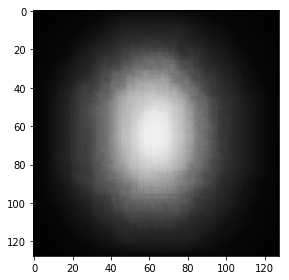

In [229]:
imshow(np.squeeze(val_mask[0]))
plt.show()